**Question 3 Imports**

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import torch
from torch import tensor
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

**Question 3.1 Load provided data**

In [314]:
labeled_train_data = pd.read_csv('Task2C_labeled.csv')
unlabeled_train_data = pd.read_csv('Task2C_unlabeled.csv')
test_data = pd.read_csv('Task2C_test.csv')
X_train_labeled = np.array(labeled_train_data.iloc[:,1:])
y_train_labeled = np.array(labeled_train_data.iloc[:,0])
X_train_unlabeled = np.array(unlabeled_train_data)
X_test_labeled = np.array(test_data.iloc[:,1:])
y_test_labeled = np.array(test_data.iloc[:,0])

**Question 3.2 Autoencoder code imported from lecture**

In [332]:
def moving_average(alist, window_size=3):
    numbers_series = pd.Series(alist)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    moving_averages_list = moving_averages.tolist()
    return(moving_averages_list[window_size - 1:])


def normalize(x, m=None, s=None): 
    if m is None or s is None:
        #print('Normalizing data: No mean and/or sd given. Assuming it is training data')
        m,s = x.mean(), x.std()
        
    return (x-m)/s

def get_dataloader(X_train,Y_train=None, autoencoder=False,bs=128, standardize=True, return_dataset=False):
    """
    Retrieves a data loader to use for training. In case autoencoder=True, Y_train automatically is set to X_train
    The function returns the dataloader only if return_dataset is False otherwise it returns a tuple (dataloader,train_dataset)
    where train_dataset is the Dataset object after preprocessing.
    """
    try:
        X_train= np.array(X_train).astype(np.float32)
        if standardize: X_train = normalize(X_train)
        if not autoencoder: Y_train = np.array(Y_train)
    except Exception as e:
        raise Exception('Make sure your input and labels are array-likes. Your input failed with exception: %s'%e)
    # transform into tensors
    if autoencoder:
        Y_train = X_train
    
    X_train, Y_train = map(tensor, (X_train, Y_train))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
            
    train_ds = TensorDataset(X_train,Y_train)
    train_dl = DataLoader(train_ds, batch_size=16)
    
    if return_dataset: return train_dl,train_ds
    
    return train_dl
    
def train_autoencoder(X_train,hidden,activation='Tanh',epochs=10, trace=True, **kwargs):
    """
    Trains an Autoencoder and returns the trained model
    
    Params:
    X_train: Input data to train the autoencoder. Can be a dataframe, numpy, 2-D list or a tensor with 2 dimensions (batch_size, flattened_image_size)
    
    hidden: a list of sizes for the hidden layers ex: ([100,2,100]) will train an autoencoder with 3 layers
    
    activation (default='Tanh'): Activation type for hidden layers, output layer will always have a linear activation
    
    epochs: Number of epochs to train autoencoder
    
    trace: if true, will display epoch progress and will plot the loss plot at the end of training
    
    **kwargs: passed to Adam optimizer, lookup adam optimizer for more details
    """
    train_dl = get_dataloader(X_train,autoencoder=True)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = n_inps
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity

    model = nn.Sequential(*layers)
    model = model.to(device)
    print('Training Model on %s'%(device))
    # to capture training loss
    losses = []
    epoch_losses = []
    # define optimizer with learning rate
    optim = Adam(model.parameters(), **kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.MSELoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = torch.mean(torch.norm(preds - yb, p=2,dim=1))
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')
    return model, epoch_losses

def get_deepfeatures(trained_model, X_input,layer_number):
    '''
    Gets deep features of a given `layer_number` upon passing `X_input` through a `trained_model`   
    '''
    X_input = get_dataloader(X_input,autoencoder=True,return_dataset=True)[1].tensors[0]
    result = []
    def save_result(m,i,o):
        result.append(o.data)
    hook = trained_model[layer_number].register_forward_hook(save_result)

    with torch.no_grad():
        trained_model(X_input)

    hook.remove()
    
    return (result[0].cpu().numpy())


**Question 3.2 Train Autoencoder**

In [339]:
epochs = 30
lr = 0.001
activation = 'Tanh'
hidden = [[i] for i in range(20, 221, 40)]
trained_models = []
for h in hidden:
    AE_model, losses = train_autoencoder(    
        X_train = np.concatenate((X_train_labeled, X_train_unlabeled),axis=0), 
        hidden = h , 
        epochs = epochs , # maximum number of epoches  
        activation = activation , # activation function
        lr = lr   #learning rate
    )
    trained_models.append([h,AE_model, losses[-1]])

Training Model on cuda:0
Epoch 0 out of 30. Loss:24.576230845500515
Epoch 3 out of 30. Loss:19.19155803169172
Epoch 6 out of 30. Loss:17.200688293299724
Epoch 9 out of 30. Loss:16.20317897599997
Epoch 12 out of 30. Loss:15.461945297791786
Epoch 15 out of 30. Loss:14.931717961104875
Epoch 18 out of 30. Loss:14.594938061900974
Epoch 21 out of 30. Loss:14.405284527650814
Epoch 24 out of 30. Loss:14.32568267940246
Epoch 27 out of 30. Loss:14.53501198955418
Training Model on cuda:0
Epoch 0 out of 30. Loss:21.88601098601351
Epoch 3 out of 30. Loss:14.408981559202843
Epoch 6 out of 30. Loss:12.473161549912286
Epoch 9 out of 30. Loss:11.46654219479905
Epoch 12 out of 30. Loss:10.711468686762544
Epoch 15 out of 30. Loss:10.333412013103052
Epoch 18 out of 30. Loss:10.399444167146978
Epoch 21 out of 30. Loss:10.391211204922076
Epoch 24 out of 30. Loss:10.033160976527892
Epoch 27 out of 30. Loss:9.755018371896645
Training Model on cuda:0
Epoch 0 out of 30. Loss:20.337262930329313
Epoch 3 out of 30

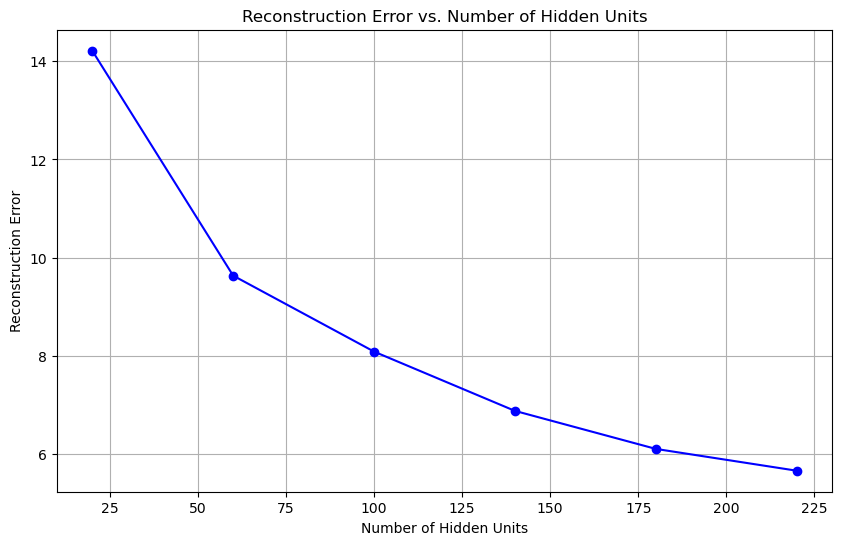

In [340]:
num_rows, num_columns = X_train_unlabeled.shape
reconstruction_error = []
for h in range(len(hidden)):
    reconstruction_error.append([hidden[h],trained_models[h][2]])
hidden_units = [reconstruction_error[0][0] for reconstruction_error in reconstruction_error]
reconstruction_errors = [reconstruction_error[1] for reconstruction_error in reconstruction_error]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hidden_units, reconstruction_errors, marker='o', color='b')
plt.title('Reconstruction Error vs. Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

**Question 3.4 Building 3-Layer NN**

In [281]:
def train_classifier(X_train,Y_train,hidden,activation='Tanh',epochs=20, trace=False,**kwargs):
    train_dl = get_dataloader(X_train,Y_train,autoencoder=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Building the autoencoder
    n_inps = [X_train.shape[-1]]
    n_out = [len(np.unique(Y_train))]   # is not a good idea if you are expecting very large datasets
    layer_dims = n_inps + hidden + n_out
    layers = []
    try:
        non_linearity = getattr(nn,activation)()
    except AttributeError:
        raise Exception('Activation type not found, note that it is case senstive (ex: Tanh, Sigmoid,ReLU)')
        
    for i in range(len(layer_dims)-1):
        layers.extend([nn.Linear(layer_dims[i], layer_dims[i+1]), non_linearity])
    
    layers.pop()  # to remove the last non-linearity
    model = nn.Sequential(*layers)
    model = model.to(device)
    # to capture training loss
    losses = []
    epoch_losses =[]
    # define optimizer with learning rate
    optim = Adam(model.parameters(),**kwargs)
    # we use MSE error for reconstruction loss
    loss_criterion = nn.CrossEntropyLoss()
    # calculate printing step - optional
    printing_step = int(epochs/10)
    # start training
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_criterion(preds,yb)
            losses.append(loss.item())
            loss.backward()
            optim.step()
            model.zero_grad()
        # after epoch
        epoch_loss = np.mean(losses[-len(train_dl):]) # average loss across all batches
        epoch_losses.append(epoch_loss)
        if trace and not epoch%printing_step:
            print(f'Epoch {epoch} out of {epochs}. Loss:{epoch_loss}')
    return model, epoch_losses


**Question 3.4 Fit and test/train error calculation**

In [282]:
hidden_units = [[i] for i in range(20, 221, 40)]
eta = 0.001
model_nn = []
losses_nn = []
for h in hidden_units:
    model, epoch_losses = train_classifier(X_train_labeled, y_train_labeled,h)
    model_nn.append(model)
    test_dl = get_dataloader(X_test_labeled,y_test_labeled,autoencoder=False)
    loss_criterion = nn.CrossEntropyLoss()
    for xb,yb in test_dl:
        preds = model(xb)
        loss = loss_criterion(preds,yb)
        losses.append(loss.item())
    total_loss = np.mean(losses[-len(test_dl):])
    losses_nn.append(total_loss)
    

In [283]:
X_train_learnt = []
X_test_learnt = []
for h in range(len(hidden)):
    X_train_learnt.append([hidden[h],np.concatenate((X_train_labeled,get_deepfeatures(trained_models[h][1],X_train_labeled,1)),axis = 1)])
    zero_features = np.zeros_like(get_deepfeatures(trained_models[h][1],X_test_labeled,1))
    X_test_learnt.append([hidden[h],np.concatenate((X_test_labeled,zero_features),axis = 1)])
hidden_units = [i for i in range(20, 221, 40)]
eta = 0.001
model_nn_learnt = []
losses_nn_learnt = []
for h in range(len(hidden)):
    model, epoch_losses = train_classifier(X_train_learnt[h][1], y_train_labeled,hidden[h])
    model_nn_learnt.append(model)
    test_dl = get_dataloader(X_test_learnt[h][1],y_test_labeled,autoencoder=False)
    loss_criterion = nn.CrossEntropyLoss()
    for xb,yb in test_dl:
        preds = model(xb)
        loss = loss_criterion(preds,yb)
        losses.append(loss.item())
    total_loss = np.mean(losses[-len(test_dl):])
    losses_nn_learnt.append(total_loss)

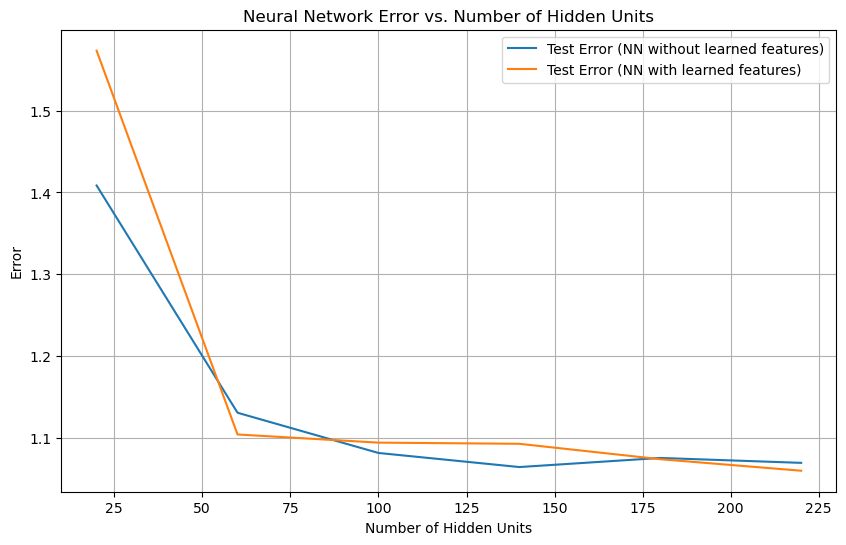

In [284]:
import matplotlib.pyplot as plt
# Extracting data
plt.figure(figsize=(10, 6))

# Plotting errors for neural networks without learned features
plt.plot(hidden, losses_nn, label='Test Error (NN without learned features)')
plt.plot(hidden, losses_nn_learnt, label='Test Error (NN with learned features)')

plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Neural Network Error vs. Number of Hidden Units')
plt.legend()
plt.grid(True)
plt.show()
